# Downloading and preprocessing annotations of coronal holes and active regions
These annotations of coronal holes and active regions were made by students of Technical University of Košice.

In included zip files `ar_custom.zip` and `ch_custom.zip` are:
- 537 annotations of coronal holes
- 533 annotations of active regions

In [1]:
import sys, os
sys.path.append('../src')

In [2]:
import glob
import re
import zipfile
from datetime import datetime
from pathlib import Path

import astropy.units as u
import numpy as np
import sunpy
from PIL import Image, ImageDraw
from sunpy.coordinates.sun import angular_radius
from sunpy.net.helioviewer import HelioviewerClient
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils import create_contours
from prep_utils import create_labels_img, create_limb_mask, crop_limb

In [3]:
# Define function for parsing files
def parse_coords(text_file):
    with open(text_file) as file:
        lines = file.readlines()
        file.close()
    events = []
    event_coords = []
    date = None
    radius = None
    for i_line, line in enumerate(lines):
        if line.find("DATE") == 0:
            date = line.split("DATE:")[-1].strip()
        elif line.find("RADIUS") == 0:
            radius = float(line.split(":")[-1].strip())
        else:
            # Check if new event coord list starts
            if line.find("CH") == 0 or line.find("AR") == 0:
                if len(event_coords) != 0:
                    events.append(event_coords)
                    event_coords = []
            else:
                line = re.split(r"\s{2,}", line)
                line = [float(s.strip()) for s in line if s != ""]
                event_coords.append(tuple(line))
    # Add last event coords
    events.append(event_coords)
    return date, radius, events

## Coronal holes

In [4]:
# Unzip data
with zipfile.ZipFile("../data/ch_custom.zip","r") as zip_ref:
    zip_ref.extractall("../data/")

In [5]:
dir_path = "../data/193(custom)/"
coord_files = glob.glob("../data/ch_custom/*.txt")
# Create required folders
Path(dir_path + "/masks/").mkdir(parents=True, exist_ok=True)

hv = HelioviewerClient()
for file in tqdm(coord_files[:10]):
    name, radius, coords = parse_coords(file)
    date = datetime.strptime(name, '%Y-%m-%d %H:%M:%S.%f')
    # Download image file from HEK
    fname = hv.download_png(date.strftime("%Y/%m/%d %H:%M:%S"), 2.4, "[SDO,AIA,AIA,193,1,100]",
                            x0=0, y0=0, width=1024, height=1024, progress=False,
                            directory=f"{dir_path}/imgs/")
    fname = fname.split("\\")[-1]
    # Create empty image
    # NOTE: Coords are made for image size of 4096x4096
    blank_img = Image.new("RGB", (4096, 4096), (0, 0, 0))
    img = ImageDraw.Draw(blank_img)
    for annotation in coords:
        try:
            img.polygon(annotation, fill=(255, 255, 255))
        except TypeError:
            pass
    blank_img.resize((1024, 1024)).save(dir_path + "/masks/" + fname)

100%|██████████| 10/10 [00:28<00:00,  2.85s/it]


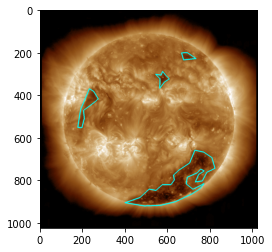

In [6]:
# Load first image and mask
img = glob.glob(f"{dir_path}/imgs/*.png")[0]
mask = glob.glob(f"{dir_path}/masks/*.png")[0]
img = Image.open(img).convert("RGB").resize((1024, 1024))
mask = Image.open(mask).convert("L").resize((1024, 1024))

# Draw contours onto images to check it match with image
coords = create_contours(mask, target_size=(1024, 1024))
img_draw = ImageDraw.Draw(img)
for annotation in coords:
    img_draw.line(annotation, fill="cyan", width=5)
plt.imshow(np.asarray(img))


In [7]:
# Create limb mask
create_limb_mask(img_size=(1024, 1024), radius=404, name=dir_path + "limb_mask.png")

# Crop limb and save as new img
imgs = glob.glob(f"{dir_path}/imgs/*.png")
limb = Image.open(dir_path + "limb_mask.png").convert("RGB")
Path(dir_path + "/imgs_prep/").mkdir(parents=True, exist_ok=True)

for img in tqdm(imgs):
    fname = img.split("\\")[-1]
    img = Image.open(img).convert("RGB")
    cropped = crop_limb(img, limb)
    cropped.save(f"{dir_path}/imgs_prep/{fname}")

100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


## Active regions


In [8]:
# Unzip data
with zipfile.ZipFile("../data/ar_custom.zip","r") as zip_ref:
    zip_ref.extractall("../data/")

In [9]:
dir_path = "../data/171(custom)/"
coord_files = glob.glob("../data/ar_custom/*.txt")
# Create required folders
Path(dir_path + "/masks/").mkdir(parents=True, exist_ok=True)

hv = HelioviewerClient()
for file in tqdm(coord_files[:10]):
    name, radius, coords = parse_coords(file)
    date = datetime.strptime(name, '%Y-%m-%d %H:%M:%S.%f')
    # Download image file from HEK
    fname = hv.download_png(date.strftime("%Y/%m/%d %H:%M:%S"), 2.4, "[SDO,AIA,AIA,171,1,100]",
                            x0=0, y0=0, width=1024, height=1024, progress=False,
                            directory=f"{dir_path}/imgs/")
    fname = fname.split("\\")[-1]
    # Create empty image
    # NOTE: Coords are made for image size of 4096x4096
    blank_img = Image.new("RGB", (4096, 4096), (0, 0, 0))
    img = ImageDraw.Draw(blank_img)
    for annotation in coords:
        try:
            img.polygon(annotation, fill=(255, 255, 255))
        except TypeError:
            pass
    blank_img.resize((1024, 1024)).save(dir_path + "/masks/" + fname)

100%|██████████| 10/10 [00:29<00:00,  2.98s/it]


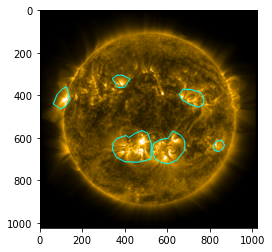

In [10]:
# Load first image and mask
img = glob.glob(f"{dir_path}/imgs/*.png")[0]
mask = glob.glob(f"{dir_path}/masks/*.png")[0]
img = Image.open(img).convert("RGB").resize((1024, 1024))
mask = Image.open(mask).convert("L").resize((1024, 1024))

# Draw contours onto images to check it match with image
coords = create_contours(mask, target_size=(1024, 1024))
img_draw = ImageDraw.Draw(img)
for annotation in coords:
    img_draw.line(annotation, fill="cyan", width=5)
plt.imshow(np.asarray(img))